# Usage of BiasBase class
### a) Relaxed scans along any CV
### b) Umbrella sampling 

To analyse the umbrella sampling results, please install 
https://github.com/ochsenfeld-lab/adaptive_sampling

### Imports

In [1]:
path_to_adaptivesampling = "/home/jdiet/AdvSampl"

In [36]:
import os
import sys
sys.path.append(path_to_adaptivesampling)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms

from nff.train import load_model
from ase import units
from nff.io.ase import AtomsBatch
from nff.io.ase_calcs import NeuralFF

In [4]:
from ase.io import Trajectory as trajectory
from ase.io import write, read
import nglview as nv
from tqdm import tqdm

In [5]:
from nff.md.nvt import Langevin
from nff.md.colvars import ColVar
from nff.io.bias_calculators import BiasBase
from nff.md.utils import BiasedNeuralMDLogger
from ase.optimize import BFGS

In [6]:
from adaptive_sampling.processing_tools import mbar

In [7]:
# allow the use of LaTeX rendering and allow for serif
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

### Loading the sarting structure

In [22]:
start_geom = read("models/ammonia/Ammonia.xyz")

In [23]:
# central dictionray for the ColVar class
# in this tutorial we will use the improper dihedral of ammonia
info_dict = {'name': 'dihedral',
             'index_list': [0, 1, 2, 3], }

atoms = AtomsBatch.from_atoms(start_geom,
                              )

# use the distance of the scan for center of umbrella window
CV = ColVar(info_dict)
cv, cv_grad = CV(atoms)

print(f"Start value: {cv*180/np.pi} degrees = {cv} radians")

Start value: 36.932241080713766 degrees = 0.6445892069987641 radians


### The scan

In [54]:
# the cv is in radians -1 to 1 is a decent choice
min_val = -1.0
max_val = 1.0
dval = 0.05  # step between minimizations
targets = np.arange(min_val, max_val+dval, dval)

In [25]:
device = 'cpu'

opt_traj = []
opt_eners = []

for target in tqdm(targets):

    # this is a list for the class to enable multidimensional PMFs
    # definition is the CV definition
    # as we do a minimization, there is no CV range, we want to set a minimum value
    # ext_k is the force constant in eV/(CV-unit)**2
    cv_defs = [{'definition': info_dict,
                'range': [target, target],
                'ext_k': 100.0,
                'type': 'angle',
                }
               ]

    # set the calculator, which is the BiasBase class
    calculator = BiasBase.from_file('models/ammonia/',
                                    cv_defs=cv_defs,
                                    directed=True,
                                    device=device)
    atoms.set_calculator(calculator)

    dyn = BFGS(atoms)

    dyn.run(fmax=0.005, steps=1000)

    opt_traj.append(atoms.copy())
    opt_eners.append(atoms.get_potential_energy())

opt_eners = np.array(opt_eners)


  0%|          | 0/41 [00:00<?, ?it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:46      135.274872      269.2839
BFGS:    1 15:10:46       75.441132      172.1286
BFGS:    2 15:10:46       34.186176      138.6160
BFGS:    3 15:10:46        6.183031       59.6669
BFGS:    4 15:10:46        1.157730       23.9854
BFGS:    5 15:10:46        0.311247        3.8004
BFGS:    6 15:10:46        0.231852        1.3560
BFGS:    7 15:10:46        0.193721        0.5203
BFGS:    8 15:10:46        0.192201        0.5462
BFGS:    9 15:10:46        0.183811        0.6466
BFGS:   10 15:10:46        0.181561        0.4909
BFGS:   11 15:10:46        0.179318        0.1061
BFGS:   12 15:10:46        0.179141        0.0167
BFGS:   13 15:10:46        0.179132        0.0046



  2%|▏         | 1/41 [00:00<00:05,  6.79it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:46        0.236670        7.9460
BFGS:    1 15:10:46        3.132580       40.8899
BFGS:    2 15:10:46        0.134008        1.8376
BFGS:    3 15:10:46        0.120068        1.0633
BFGS:    4 15:10:46        0.117956        0.1046
BFGS:    5 15:10:46        0.117878        0.0410
BFGS:    6 15:10:46        0.117795        0.0301
BFGS:    7 15:10:46        0.117769        0.0293
BFGS:    8 15:10:46        0.117760        0.0090
BFGS:    9 15:10:46        0.117760        0.0022
      Step     Time          Energy         fmax
BFGS:    0 15:10:46        0.187839        7.8743
BFGS:    1 15:10:46        2.906069       39.5176
BFGS:    2 15:10:46        0.083307        1.6682
BFGS:    3 15:10:46        0.071290        0.9027
BFGS:    4 15:10:46        0.069771        0.0995
BFGS:    5 15:10:46        0.069686        0.0375
BFGS:    6 15:10:46        0.069574        0.0450
BFGS:    7 15:10:46        0.069550        0.0311
BF


  7%|▋         | 3/41 [00:00<00:03, 10.57it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:46        0.153181        7.8333
BFGS:    1 15:10:46        2.734924       38.4386
BFGS:    2 15:10:46        0.046921        1.5410
BFGS:    3 15:10:46        0.036460        0.7844
BFGS:    4 15:10:46        0.035300        0.0980
BFGS:    5 15:10:46        0.035192        0.0396
BFGS:    6 15:10:46        0.035033        0.0601
BFGS:    7 15:10:46        0.035010        0.0323
BFGS:    8 15:10:46        0.035003        0.0047
      Step     Time          Energy         fmax
BFGS:    0 15:10:46        0.132324        7.8161
BFGS:    1 15:10:46        2.611789       37.6169
BFGS:    2 15:10:46        0.024465        1.4538
BFGS:    3 15:10:46        0.015255        0.6980
BFGS:    4 15:10:46        0.014300        0.0987
BFGS:    5 15:10:46        0.014154        0.0468
BFGS:    6 15:10:46        0.013935        0.0764
BFGS:    7 15:10:46        0.013909        0.0357
BFGS:    8 15:10:47        0.013902        0.0042



 12%|█▏        | 5/41 [00:00<00:02, 12.29it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.124318        7.8306
BFGS:    1 15:10:47        2.536058       37.0539
BFGS:    2 15:10:47        0.014936        1.4011
BFGS:    3 15:10:47        0.006679        0.6426
BFGS:    4 15:10:47        0.005810        0.1030
BFGS:    5 15:10:47        0.005607        0.0543
BFGS:    6 15:10:47        0.005322        0.0961
BFGS:    7 15:10:47        0.005284        0.0431
BFGS:    8 15:10:47        0.005276        0.0048
      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.127464        7.8713
BFGS:    1 15:10:47        2.501063       36.7129
BFGS:    2 15:10:47        0.016793        1.3828
BFGS:    3 15:10:47        0.009189        0.6187
BFGS:    4 15:10:47        0.008306        0.1107
BFGS:    5 15:10:47        0.008030        0.0620
BFGS:    6 15:10:47        0.007671        0.1153
BFGS:    7 15:10:47        0.007615        0.0519
BFGS:    8 15:10:47        0.007605        0.0057
BF


 17%|█▋        | 7/41 [00:00<00:02, 12.81it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.139864        7.9433
BFGS:    1 15:10:47        2.506310       36.6002
BFGS:    2 15:10:47        0.028278        1.3999
BFGS:    3 15:10:47        0.020973        0.6347
BFGS:    4 15:10:47        0.019965        0.1230
BFGS:    5 15:10:47        0.019603        0.0743
BFGS:    6 15:10:47        0.019150        0.1315
BFGS:    7 15:10:47        0.019070        0.0605
BFGS:    8 15:10:47        0.019056        0.0068
BFGS:    9 15:10:47        0.019055        0.0014
      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.159471        8.0396
BFGS:    1 15:10:47        2.548075       36.7114
BFGS:    2 15:10:47        0.047549        1.4630
BFGS:    3 15:10:47        0.040146        0.7016
BFGS:    4 15:10:47        0.038855        0.1384
BFGS:    5 15:10:47        0.038411        0.0828
BFGS:    6 15:10:47        0.037824        0.1434
BFGS:    7 15:10:47        0.037719        0.0673
BF


 22%|██▏       | 9/41 [00:00<00:02, 12.96it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.184332        8.1633
BFGS:    1 15:10:47        2.627866       37.0810
BFGS:    2 15:10:47        0.072882        1.5842
BFGS:    3 15:10:47        0.064941        0.8433
BFGS:    4 15:10:47        0.063064        0.1561
BFGS:    5 15:10:47        0.062545        0.0907
BFGS:    6 15:10:47        0.061767        0.1493
BFGS:    7 15:10:47        0.061641        0.0701
BFGS:    8 15:10:47        0.061617        0.0074
BFGS:    9 15:10:47        0.061616        0.0016
      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.212569        8.3135
BFGS:    1 15:10:47        2.746790       37.7475
BFGS:    2 15:10:47        0.102723        1.7841
BFGS:    3 15:10:47        0.093854        1.1021
BFGS:    4 15:10:47        0.090716        0.1727
BFGS:    5 15:10:47        0.090128        0.1035
BFGS:    6 15:10:47        0.089098        0.1421
BFGS:    7 15:10:47        0.088966        0.0643
BF


 27%|██▋       | 11/41 [00:00<00:02, 13.04it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.242380        8.4869
BFGS:    1 15:10:47        2.904392       38.7396
BFGS:    2 15:10:47        0.135826        2.0872
BFGS:    3 15:10:47        0.126026        1.5497
BFGS:    4 15:10:47        0.120030        0.1826
BFGS:    5 15:10:47        0.119362        0.1243
BFGS:    6 15:10:47        0.118065        0.1166
BFGS:    7 15:10:47        0.117928        0.0511
BFGS:    8 15:10:47        0.117896        0.0044
      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.272102        8.6761
BFGS:    1 15:10:47        3.098192       40.0717
BFGS:    2 15:10:47        0.171420        2.5215
BFGS:    3 15:10:47        0.162023        2.2966
BFGS:    4 15:10:47        0.149403        0.1761
BFGS:    5 15:10:47        0.148630        0.1513
BFGS:    6 15:10:47        0.147130        0.0758
BFGS:    7 15:10:47        0.146955        0.0451
BFGS:    8 15:10:47        0.146906        0.0048



 32%|███▏      | 13/41 [00:01<00:02, 13.49it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.300434        8.8748
BFGS:    1 15:10:47        3.320655       41.7050
BFGS:    2 15:10:47        0.209205        3.0901
BFGS:    3 15:10:47        0.204971        3.4795
BFGS:    4 15:10:47        0.177569        0.1913
BFGS:    5 15:10:47        0.176622        0.1805
BFGS:    6 15:10:47        0.175065        0.0903
BFGS:    7 15:10:47        0.174745        0.0563
BFGS:    8 15:10:47        0.174645        0.0115
BFGS:    9 15:10:47        0.174641        0.0021
      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.326322        9.0721
BFGS:    1 15:10:47        3.560904       43.5734
BFGS:    2 15:10:47        0.249064        3.7780
BFGS:    3 15:10:47        0.261389        5.2362
BFGS:    4 15:10:47        0.203620        0.2423
BFGS:    5 15:10:47        0.202334        0.2053
BFGS:    6 15:10:47        0.200878        0.2106
BFGS:    7 15:10:47        0.200298        0.0950
BF


 37%|███▋      | 15/41 [00:01<00:01, 13.13it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.349035        9.2607
BFGS:    1 15:10:47        3.811039       45.6261
BFGS:    2 15:10:47        0.290784        4.5562
BFGS:    3 15:10:47        0.341028        7.6801
BFGS:    4 15:10:47        0.226994        0.3210
BFGS:    5 15:10:47        0.225034        0.2169
BFGS:    6 15:10:47        0.223669        0.2993
BFGS:    7 15:10:47        0.222836        0.1903
BFGS:    8 15:10:47        0.222464        0.0408
BFGS:    9 15:10:47        0.222421        0.0092
BFGS:   10 15:10:47        0.222418        0.0025
      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.367976        9.4323
BFGS:    1 15:10:47        4.059730       47.7759
BFGS:    2 15:10:47        0.333419        5.3653
BFGS:    3 15:10:47        0.452796       10.8040
BFGS:    4 15:10:47        0.247446        0.4283
BFGS:    5 15:10:47        0.244240        0.2154
BFGS:    6 15:10:47        0.242811        0.3500
BF


 41%|████▏     | 17/41 [00:01<00:01, 12.46it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:47        0.382903        9.5815
BFGS:    1 15:10:47        4.293952       49.9045
BFGS:    2 15:10:47        0.374874        6.1250
BFGS:    3 15:10:47        0.595966       14.3631
BFGS:    4 15:10:47        0.264828        0.7909
BFGS:    5 15:10:47        0.259684        0.2323
BFGS:    6 15:10:47        0.257990        0.3867
BFGS:    7 15:10:47        0.256937        0.3621
BFGS:    8 15:10:48        0.256122        0.1272
BFGS:    9 15:10:48        0.256009        0.0203
BFGS:   10 15:10:48        0.256000        0.0053
BFGS:   11 15:10:48        0.255999        0.0011
      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.393753        9.7048
BFGS:    1 15:10:48        4.500976       51.8862
BFGS:    2 15:10:48        0.411938        6.7540
BFGS:    3 15:10:48        0.751292       17.8279
BFGS:    4 15:10:48        0.278742        1.1939
BFGS:    5 15:10:48        0.271171        0.3051
BF


 46%|████▋     | 19/41 [00:01<00:01, 11.91it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.400237        9.7947
BFGS:    1 15:10:48        4.668718       53.6130
BFGS:    2 15:10:48        0.441157        7.2011
BFGS:    3 15:10:48        0.884345       20.5581
BFGS:    4 15:10:48        0.288372        1.5690
BFGS:    5 15:10:48        0.278411        0.4104
BFGS:    6 15:10:48        0.275773        0.4480
BFGS:    7 15:10:48        0.274668        0.4555
BFGS:    8 15:10:48        0.273271        0.1597
BFGS:    9 15:10:48        0.273149        0.0228
BFGS:   10 15:10:48        0.273140        0.0059
BFGS:   11 15:10:48        0.273139        0.0015
      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.402408        9.8500
BFGS:    1 15:10:48        4.787040       54.9767
BFGS:    2 15:10:48        0.459258        7.4289
BFGS:    3 15:10:48        0.957034       21.9677
BFGS:    4 15:10:48        0.292763        1.8473
BFGS:    5 15:10:48        0.281084        0.4966
BF


 51%|█████     | 21/41 [00:01<00:01, 11.67it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.400258        9.8686
BFGS:    1 15:10:48        4.848181       55.8938
BFGS:    2 15:10:48        0.464084        7.4303
BFGS:    3 15:10:48        0.948938       21.8004
BFGS:    4 15:10:48        0.291173        1.9842
BFGS:    5 15:10:48        0.278924        0.5281
BFGS:    6 15:10:48        0.275891        0.4594
BFGS:    7 15:10:48        0.274836        0.4640
BFGS:    8 15:10:48        0.273237        0.1355
BFGS:    9 15:10:48        0.273147        0.0180
BFGS:   10 15:10:48        0.273139        0.0060
BFGS:   11 15:10:48        0.273140        0.0014
      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.393797        9.8500
BFGS:    1 15:10:48        4.847700       56.3084
BFGS:    2 15:10:48        0.455017        7.2216
BFGS:    3 15:10:48        0.866731       20.1941
BFGS:    4 15:10:48        0.283433        1.9637
BFGS:    5 15:10:48        0.271899        0.4955
BF


 56%|█████▌    | 23/41 [00:01<00:01, 10.91it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.383071        9.7945
BFGS:    1 15:10:48        4.785023       56.1955
BFGS:    2 15:10:48        0.432994        6.8363
BFGS:    3 15:10:48        0.737595       17.5776
BFGS:    4 15:10:48        0.270006        1.7982
BFGS:    5 15:10:48        0.260245        0.4131
BFGS:    6 15:10:48        0.258102        0.3903
BFGS:    7 15:10:48        0.257274        0.3975
BFGS:    8 15:10:48        0.256102        0.1337
BFGS:    9 15:10:48        0.256008        0.0193
BFGS:   10 15:10:48        0.256000        0.0064
BFGS:   11 15:10:48        0.255999        0.0016
      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.368175        9.7042
BFGS:    1 15:10:48        4.663617       55.5630
BFGS:    2 15:10:48        0.400179        6.3172
BFGS:    3 15:10:48        0.593889       14.4858
BFGS:    4 15:10:48        0.251780        1.5247
BFGS:    5 15:10:48        0.244351        0.3101
BF


 61%|██████    | 25/41 [00:02<00:01, 10.39it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.349296        9.5819
BFGS:    1 15:10:48        4.490657       54.4492
BFGS:    2 15:10:48        0.359435        5.7110
BFGS:    3 15:10:48        0.460321       11.3936
BFGS:    4 15:10:48        0.229743        1.1956
BFGS:    5 15:10:48        0.224642        0.2188
BFGS:    6 15:10:48        0.223625        0.2764
BFGS:    7 15:10:48        0.223089        0.2749
BFGS:    8 15:10:48        0.222517        0.1080
BFGS:    9 15:10:48        0.222428        0.0204
BFGS:   10 15:10:48        0.222418        0.0066
BFGS:   11 15:10:48        0.222417        0.0017
      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.326749        9.4321
BFGS:    1 15:10:48        4.276317       52.9196
BFGS:    2 15:10:48        0.313792        5.0631
BFGS:    3 15:10:48        0.349218        8.6275
BFGS:    4 15:10:48        0.204742        0.8660
BFGS:    5 15:10:48        0.201550        0.1595
BF


 66%|██████▌   | 27/41 [00:02<00:01, 10.12it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:48        0.301034        9.2598
BFGS:    1 15:10:48        4.032947       51.0624
BFGS:    2 15:10:48        0.266043        4.4143
BFGS:    3 15:10:48        0.262445        6.3505
BFGS:    4 15:10:48        0.177459        0.5793
BFGS:    5 15:10:48        0.175600        0.1293
BFGS:    6 15:10:48        0.175185        0.1657
BFGS:    7 15:10:48        0.174917        0.1327
BFGS:    8 15:10:49        0.174700        0.0451
BFGS:    9 15:10:49        0.174647        0.0166
BFGS:   10 15:10:49        0.174641        0.0057
BFGS:   11 15:10:49        0.174641        0.0010
      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.272886        9.0713
BFGS:    1 15:10:49        3.774252       48.9842
BFGS:    2 15:10:49        0.218533        3.7989
BFGS:    3 15:10:49        0.196071        4.5960
BFGS:    4 15:10:49        0.148559        0.3599
BFGS:    5 15:10:49        0.147513        0.1110
BF


 71%|███████   | 29/41 [00:02<00:01, 10.28it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.243206        8.8710
BFGS:    1 15:10:49        3.513157       46.7998
BFGS:    2 15:10:49        0.173131        3.2434
BFGS:    3 15:10:49        0.144578        3.3160
BFGS:    4 15:10:49        0.118881        0.2149
BFGS:    5 15:10:49        0.118279        0.0937
BFGS:    6 15:10:49        0.118095        0.0735
BFGS:    7 15:10:49        0.118006        0.0443
BFGS:    8 15:10:49        0.117919        0.0274
BFGS:    9 15:10:49        0.117897        0.0107
BFGS:   10 15:10:49        0.117895        0.0027
      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.213583        8.6737
BFGS:    1 15:10:49        3.267763       44.6556
BFGS:    2 15:10:49        0.131457        2.7650
BFGS:    3 15:10:49        0.103407        2.4265
BFGS:    4 15:10:49        0.089582        0.1412
BFGS:    5 15:10:49        0.089197        0.0771
BFGS:    6 15:10:49        0.089062        0.0392
BF


 76%|███████▌  | 31/41 [00:02<00:00, 10.75it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.185487        8.4849
BFGS:    1 15:10:49        3.049598       42.6727
BFGS:    2 15:10:49        0.094809        2.3732
BFGS:    3 15:10:49        0.069810        1.8347
BFGS:    4 15:10:49        0.062104        0.1242
BFGS:    5 15:10:49        0.061815        0.0618
BFGS:    6 15:10:49        0.061707        0.0317
BFGS:    7 15:10:49        0.061672        0.0285
BFGS:    8 15:10:49        0.061622        0.0133
BFGS:    9 15:10:49        0.061617        0.0037
      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.160588        8.3117
BFGS:    1 15:10:49        2.868820       40.9585
BFGS:    2 15:10:49        0.064411        2.0694
BFGS:    3 15:10:49        0.042804        1.4567
BFGS:    4 15:10:49        0.038130        0.1322
BFGS:    5 15:10:49        0.037875        0.0485
BFGS:    6 15:10:49        0.037781        0.0293
BFGS:    7 15:10:49        0.037747        0.0265
BF


 80%|████████  | 33/41 [00:02<00:00, 11.10it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.141023        8.1626
BFGS:    1 15:10:49        2.734402       39.5968
BFGS:    2 15:10:49        0.041523        1.8427
BFGS:    3 15:10:49        0.022697        1.2246
BFGS:    4 15:10:49        0.019487        0.1459
BFGS:    5 15:10:49        0.019231        0.0398
BFGS:    6 15:10:49        0.019143        0.0300
BFGS:    7 15:10:49        0.019102        0.0267
BFGS:    8 15:10:49        0.019061        0.0135
BFGS:    9 15:10:49        0.019055        0.0044
      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.128623        8.0403
BFGS:    1 15:10:49        2.648529       38.6104
BFGS:    2 15:10:49        0.027457        1.6829
BFGS:    3 15:10:49        0.010597        1.0892
BFGS:    4 15:10:49        0.008072        0.1591
BFGS:    5 15:10:49        0.007798        0.0390
BFGS:    6 15:10:49        0.007706        0.0328
BFGS:    7 15:10:49        0.007650        0.0276
BF


 85%|████████▌ | 35/41 [00:03<00:00, 11.24it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.125348        7.9448
BFGS:    1 15:10:49        2.611239       37.9919
BFGS:    2 15:10:49        0.023656        1.5764
BFGS:    3 15:10:49        0.008039        1.0169
BFGS:    4 15:10:49        0.005812        0.1711
BFGS:    5 15:10:49        0.005505        0.0422
BFGS:    6 15:10:49        0.005399        0.0376
BFGS:    7 15:10:49        0.005320        0.0283
BFGS:    8 15:10:49        0.005282        0.0167
BFGS:    9 15:10:49        0.005276        0.0043
      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.133102        7.8758
BFGS:    1 15:10:49        2.622643       37.7278
BFGS:    2 15:10:49        0.031632        1.5129
BFGS:    3 15:10:49        0.016682        0.9875
BFGS:    4 15:10:49        0.014544        0.1830
BFGS:    5 15:10:49        0.014185        0.0481
BFGS:    6 15:10:49        0.014052        0.0498
BFGS:    7 15:10:49        0.013946        0.0302
BF


 90%|█████████ | 37/41 [00:03<00:00, 11.74it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.153531        7.8346
BFGS:    1 15:10:49        2.684723       37.8191
BFGS:    2 15:10:49        0.052738        1.4870
BFGS:    3 15:10:49        0.037988        0.9912
BFGS:    4 15:10:49        0.035797        0.1967
BFGS:    5 15:10:49        0.035362        0.0555
BFGS:    6 15:10:49        0.035186        0.0641
BFGS:    7 15:10:49        0.035051        0.0348
BFGS:    8 15:10:49        0.035009        0.0178
BFGS:    9 15:10:49        0.035003        0.0039
      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.187721        7.8221
BFGS:    1 15:10:49        2.800468       38.2760
BFGS:    2 15:10:49        0.087866        1.4962
BFGS:    3 15:10:49        0.072901        1.0251
BFGS:    4 15:10:49        0.070538        0.2134
BFGS:    5 15:10:49        0.069997        0.0636
BFGS:    6 15:10:49        0.069764        0.0797
BFGS:    7 15:10:49        0.069599        0.0393
BF


 95%|█████████▌| 39/41 [00:03<00:00, 12.09it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:10:49        0.235975        7.8383
BFGS:    1 15:10:49        2.973159       39.1121
BFGS:    2 15:10:49        0.137249        1.5407
BFGS:    3 15:10:49        0.121664        1.0917
BFGS:    4 15:10:49        0.119002        0.2342
BFGS:    5 15:10:49        0.118327        0.0753
BFGS:    6 15:10:49        0.118024        0.0955
BFGS:    7 15:10:49        0.117827        0.0440
BFGS:    8 15:10:49        0.117768        0.0219
BFGS:    9 15:10:50        0.117760        0.0068
BFGS:   10 15:10:50        0.117759        0.0018
      Step     Time          Energy         fmax
BFGS:    0 15:10:50        0.297743        7.8771
BFGS:    1 15:10:50        3.201794       40.3101
BFGS:    2 15:10:50        0.200392        1.6200
BFGS:    3 15:10:50        0.183783        1.1952
BFGS:    4 15:10:50        0.180669        0.2595
BFGS:    5 15:10:50        0.179839        0.0869
BFGS:    6 15:10:50        0.179445        0.1113
BF

100%|██████████| 41/41 [00:03<00:00, 11.62it/s]


In [26]:
nv.show_asetraj(opt_traj)

NGLWidget(max_frame=40)

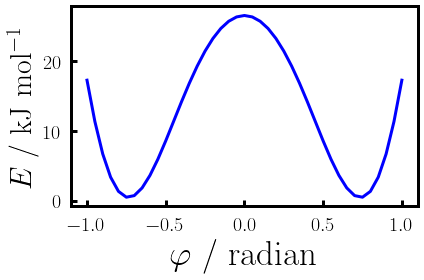

In [34]:
fig, ax = plt.subplots(1, sharex=True)

ax.plot(targets, opt_eners*units.mol/units.kJ, linewidth=3, color='blue')

ax.spines['bottom'].set_linewidth('3')
ax.spines['top'].set_linewidth('3')
ax.spines['left'].set_linewidth('3')
ax.spines['right'].set_linewidth('3')
ax.tick_params(axis='y', length=6, width=3,
               labelsize=20, pad=10, direction='in')
ax.tick_params(axis='x', length=6, width=3,
               labelsize=20, pad=10, direction='in')

ax.set_ylabel(r'$E$ / kJ mol$^{-1}$', fontsize=30)
ax.set_xlabel(r'$\varphi$ / radian', fontsize=35)

plt.tight_layout()
plt.show()

### Umbrella Sampling

In [58]:
os.mkdir("16_UmbrellaWindows")

In [59]:
# sequential simulation of umbrella windows
# for larger systems this is not effective,
# the strength of umbr sampl is the parallelization
for ii, target in enumerate(targets):

    # this is a list for the class to enable multidimensional PMFs
    # definition is the CV definition
    # as we do a minimization, there is no CV range, we want to set a minimum value
    # ext_sigma is the thermal coupling width,
    # which will translate into a force constant depending on the temperature
    cv_defs = [{'definition': info_dict,
                'range': [target, target],
                'ext_sigma': dval/2,
                'type': 'angle',
                }
               ]

    # set the calculator, which is the BiasBase class
    calculator = BiasBase.from_file('models/ammonia/',
                                    cv_defs=cv_defs,
                                    directed=True,
                                    device=device)
    atoms = AtomsBatch.from_atoms(opt_traj[ii],
                                  )
    atoms.set_calculator(calculator)

    dyn = Langevin(atoms,
                   timestep=0.5,
                   temperature=300.0,
                   friction_per_ps=1.0,
                   maxwell_temp=300.0,
                   logfile=f'16_UmbrellaWindows/window_{ii:02d}.log',
                   trajectory=f'16_UmbrellaWindows/window_{ii:02d}.traj',
                   )

    dyn.attach(BiasedNeuralMDLogger(dyn,
                                    atoms,
                                    f'16_UmbrellaWindows/window_{ii:02d}_ext.log',
                                    header=True,
                                    mode="w"),
               interval=4)
    # For ammonia 1ps per window should be enough
    dyn.run(steps=2000)

THE RANDOM NUMBER SEED WAS: 256464790


100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


THE RANDOM NUMBER SEED WAS: 1060723324


100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


THE RANDOM NUMBER SEED WAS: 1684187586


100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


THE RANDOM NUMBER SEED WAS: 79303695


100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


THE RANDOM NUMBER SEED WAS: 764142961


100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


THE RANDOM NUMBER SEED WAS: 24045292


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


THE RANDOM NUMBER SEED WAS: 1849409161


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


THE RANDOM NUMBER SEED WAS: 1012009338


100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


THE RANDOM NUMBER SEED WAS: 436674544


100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


THE RANDOM NUMBER SEED WAS: 1663118260


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


THE RANDOM NUMBER SEED WAS: 182853862


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


THE RANDOM NUMBER SEED WAS: 2109121441


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


THE RANDOM NUMBER SEED WAS: 210447724


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


THE RANDOM NUMBER SEED WAS: 1951271786


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


THE RANDOM NUMBER SEED WAS: 219589749


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


THE RANDOM NUMBER SEED WAS: 806441646


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


THE RANDOM NUMBER SEED WAS: 1750138288


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


THE RANDOM NUMBER SEED WAS: 1601887793


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


THE RANDOM NUMBER SEED WAS: 1134361219


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


THE RANDOM NUMBER SEED WAS: 1699640979


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


THE RANDOM NUMBER SEED WAS: 1745069354


100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


THE RANDOM NUMBER SEED WAS: 1853959128


100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


THE RANDOM NUMBER SEED WAS: 1471354277


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


THE RANDOM NUMBER SEED WAS: 555146737


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


THE RANDOM NUMBER SEED WAS: 1246222863


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


THE RANDOM NUMBER SEED WAS: 2146435798


100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


THE RANDOM NUMBER SEED WAS: 1164583904


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


THE RANDOM NUMBER SEED WAS: 617513412


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


THE RANDOM NUMBER SEED WAS: 1547007259


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


THE RANDOM NUMBER SEED WAS: 454623487


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


THE RANDOM NUMBER SEED WAS: 1332204597


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


THE RANDOM NUMBER SEED WAS: 704467069


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


THE RANDOM NUMBER SEED WAS: 1714100193


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


THE RANDOM NUMBER SEED WAS: 1490154334


100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


THE RANDOM NUMBER SEED WAS: 1575894874


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


THE RANDOM NUMBER SEED WAS: 1317580464


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


THE RANDOM NUMBER SEED WAS: 1610595323


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


THE RANDOM NUMBER SEED WAS: 1103674290


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


THE RANDOM NUMBER SEED WAS: 1917168500


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


THE RANDOM NUMBER SEED WAS: 968097874


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


THE RANDOM NUMBER SEED WAS: 1989518548


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


### Analysis of the data

In [60]:
# How to load the data

trajs = []
meta_f = np.zeros(shape=(len(targets), 3))
for ii in range(len(targets)):
    data = np.genfromtxt(
        f"16_UmbrellaWindows/window_{ii:02d}_ext.log", skip_header=1)
    trajs.append(data[:, 4])

# The targets can also be read from the log files
meta_f[:, 1] = targets
# since we used ext_sigma and not ext_k, we need to calculate the k
# k = (RT)/(sigma**2)
meta_f[:, 2] = (8.314 * 300.0 / 1000.0) / ((dval/2)**2)

all_frames = trajs[0]
for traj in trajs[1:]:
    all_frames = np.concatenate((all_frames, traj))

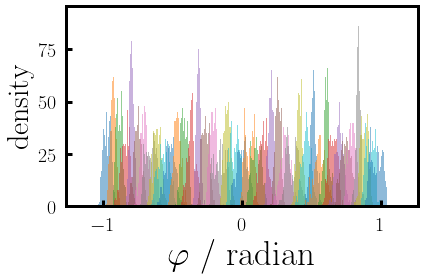

In [61]:
fig, ax = plt.subplots(1, sharex=True)

for traj, target in zip(trajs, targets):
    ax.hist(traj, alpha=0.5, bins=50, range=(target-3*dval, target+3*dval))

ax.spines['bottom'].set_linewidth('3')
ax.spines['top'].set_linewidth('3')
ax.spines['left'].set_linewidth('3')
ax.spines['right'].set_linewidth('3')
ax.tick_params(axis='y', length=6, width=3,
               labelsize=20, pad=10, direction='in')
ax.tick_params(axis='x', length=6, width=3,
               labelsize=20, pad=10, direction='in')

ax.set_ylabel(r'density', fontsize=30)
ax.set_xlabel(r'$\varphi$ / radian', fontsize=35)

plt.tight_layout()
plt.show()

In [62]:
# Get the unbiased weights with MBAR
W = mbar.run_mbar(traj_list=trajs,
                  meta_f=meta_f,
                  max_iter=int(1e6),
                  conv=1.0e-6,
                  outfreq=50,
                  equil_temp=300.0)

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv=  1.0319918767	Conv_errvec=    198.373019
Iter   50:	Conv=  0.0340141609	Conv_errvec=     16.453827
Iter  100:	Conv=  0.0301282656	Conv_errvec=      9.835515
Iter  150:	Conv=  0.0223011798	Conv_errvec=      6.303423
Iter  200:	Conv=  0.0163585767	Conv_errvec=      4.348742
Iter  250:	Conv=  0.0120106869	Conv_errvec=      3.114896
Iter  300:	Conv=  0.0088257008	Conv_errvec=      2.266864
Iter  350:	Conv=  0.0064884722	Conv_errvec=      1.660143
Iter  400:	Conv=  0.0047718467	Conv_errvec=      1.218749
Iter  450:	Conv=  0.0035104760	Conv_errvec=      0.895509
Iter  500:	Conv=  0.0025833819	Conv_errvec=      0.658201
Iter  550:	Conv=  0.0019018494	Conv_errvec=      0.483823
Iter  600:	Conv=  0.0014007546	Conv_errvec=      0.355648
Iter  650:	Conv=  0.0010322663	Conv_errvec=      0.261426
Iter  700:	Conv=  0.0007612442	Conv_errvec=      0.192162
Iter  750:	Conv=  0.0005618667	Conv_errvec=      0.1

In [72]:
# grid for PMF, let's make it a bit finer than the window placements
minimum = all_frames.min()
maximum = all_frames.max()
bin_width = dval/2
grid = np.arange(minimum, maximum, bin_width)

In [73]:
pmf, rho = mbar.pmf_from_weights(grid, all_frames, W, equil_temp=300.0)

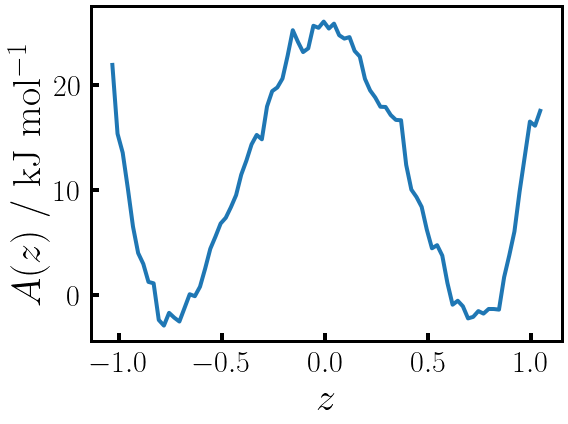

In [74]:
# even though these simulations are a bit of overkill,
# the PMF looks suprisingly poor
fig, axs = plt.subplots(1, figsize=(8, 6))

axs.plot(grid, pmf, linewidth=4)

axs.tick_params(axis='y', length=8, width=4,
                labelsize=30, pad=10, direction='in')
axs.tick_params(axis='x', length=8, width=4,
                labelsize=30, pad=10, direction='in')

axs.set_xlabel(r'$z$', fontsize=40)
axs.set_ylabel(r'$A(z)$ / kJ mol$^{-1}$', fontsize=40)
axs.spines['bottom'].set_linewidth('3')
axs.spines['top'].set_linewidth('3')
axs.spines['left'].set_linewidth('3')
axs.spines['right'].set_linewidth('3')

fig.tight_layout()
plt.show()